In [1]:
import heeps
from astropy.io import fits
import os.path
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import proper
from heeps.optics import apodizer, fp_mask, lyot_stop, detector
from heeps.wavefront import propagate_one, get_wf

## Find RAVC parameters for nominal pupil diameter values

In [2]:
pupil_img_size = 39.9988
diam_allglass = 36.905
diam_nom_ext = 38.542
diam_nom_int = 10.952
# central obscuration radius, using nominal pupil diameters
r_nom = diam_nom_int/diam_nom_ext
ra_t0 = 1 - (r_nom**2 + r_nom*np.sqrt(r_nom**2 + 8))/4
ra_r0 = r_nom/np.sqrt(1 - ra_t0)
# calculate radius wrt 'allglass' diameter
ra_r0 *= diam_nom_ext/diam_allglass
print('for nominal diameters: ravc_t=%s, ravc_r=%s'%(round(ra_t0, 3), round(ra_r0, 3)))

for nominal diameters: ravc_t=0.778, ravc_r=0.63


## Find RAVC parameters for mean diameter values

(10526, 10526)

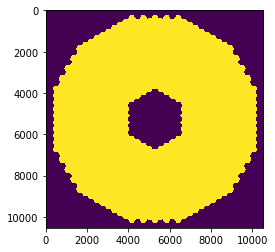

In [3]:
pup = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/mask_M1.fits')
plt.imshow(pup)
pup.shape

In [4]:
npupil = pup.shape[0]
dn = 2/npupil
pup_range = np.arange(-1, 1, dn) + dn/2
xi,yi = np.meshgrid(pup_range, pup_range)
ri = np.abs(xi + 1j*yi)
tota_area = npupil**2
outer_area = np.sum((1-pup)[ri>0.5])
inner_area = np.sum((1-pup)[ri<0.5])
r_ext = np.sqrt((tota_area - outer_area)/np.pi)
r_int = np.sqrt(inner_area/np.pi)
diam_ext = 2*r_ext/npupil*pupil_img_size
diam_int = 2*r_int/npupil*pupil_img_size
print('diam_ext=%s, diam_int=%s'%(round(diam_ext, 3), round(diam_int, 3)))
# central obscuration radius, using mean diameters
r_obstr = diam_int/diam_ext
ra_t1 = 1 - (r_obstr**2 + r_obstr*np.sqrt(r_obstr**2 + 8))/4
ra_r1 = r_obstr/np.sqrt(1 - ra_t1)
# calculate radius wrt 'allglass' diameter
ra_r1 *= diam_ext/diam_allglass
print('ravc_t=%s, ravc_r=%s'%(round(ra_t1, 3), round(ra_r1, 3)))

diam_ext=37.812, diam_int=10.196
ravc_t=0.79, ravc_r=0.603


## Examine contrast and throughtput, function of ravc_r and ravc_t

In [5]:
conf = dict(
    dir_current = '/Users/cdelacroix/INSTRUMENTS/METIS/heeps_analysis',
    file_pupil = 'pupils/ELT_fullM1.fits',
    ravc_calc = False,
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)

rs = np.linspace(0.3, 0.65, 30)
ts = np.linspace(0.3, 0.85, 50)
contrast = np.zeros((len(rs),len(ts)))
thruput = np.zeros((len(rs),len(ts)))
best_C = []
best_T = []
best_CT2 = []
t_C = []
t_T = []
t_CT2 = []
for i,r in enumerate(rs):
    if not i%6:
        print('i=%s'%i)
    for j,t in enumerate(ts):
        conf['ravc_r'] = r
        conf['ravc_t'] = t
        offaxis = propagate_one(deepcopy(wf), onaxis=False, savefits=False, verbose=False, **conf)
        thruput[i,j] = np.sum(offaxis) 
        onaxis = propagate_one(deepcopy(wf), onaxis=True, savefits=False, verbose=False, **conf)
        contrast[i,j] = np.sum(onaxis) 
        if j==0:
            best_C.append(contrast[i,j])
            best_T.append(thruput[i,j])
            best_CT2.append(contrast[i,j]/thruput[i,j]**2)
            t_C.append(t)
            t_T.append(t)
            t_CT2.append(t)
        else:
            if contrast[i,j] < best_C[-1]:
                best_C[-1] = contrast[i,j]
                t_C[-1] = t
            if thruput[i,j] > best_T[-1]:
                best_T[-1] = thruput[i,j]
                t_T[-1] = t
            CT2 = contrast[i,j]/thruput[i,j]**2
            if CT2 < best_CT2[-1]:
                best_CT2[-1] = CT2
                t_CT2[-1] = t

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2568
   ravc_calc=False, ravc_t=0.7903, ravc_r=0.6033
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)

Load pupil from 'ELT_fullM1.fits'
i=0
i=6
i=12
i=18
i=24


## Contrast map

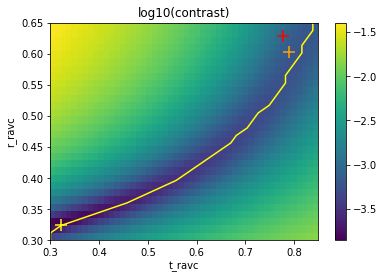

In [6]:
import matplotlib.pyplot as plt
plt.imshow(np.log10(contrast), origin='lower', extent=(ts[0],ts[-1],rs[0],rs[-1]), aspect='auto')
plt.colorbar()
plt.plot(t_C, rs, c='yellow')
plt.scatter(ra_t0, ra_r0, s=150, c='red', marker='+')
plt.scatter(ra_t1, ra_r1, s=150, c='orange', marker='+')
ind_min = np.unravel_index(np.argmin(contrast, axis=None), contrast.shape)
plt.scatter(ts[ind_min[1]], rs[ind_min[0]], s=150, c='yellow', marker='+')
plt.xlabel('t_ravc');
plt.ylabel('r_ravc');
plt.title('log10(contrast)');
plt.savefig('map_contrast.png')

## Throughput map

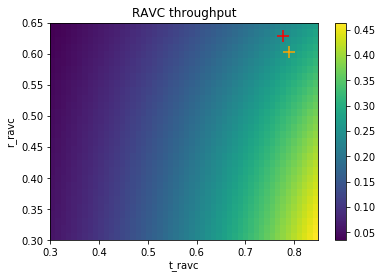

In [7]:
import matplotlib.pyplot as plt
plt.imshow((thruput), origin='lower', extent=(ts[0],ts[-1],rs[0],rs[-1]), aspect='auto')
plt.colorbar()
plt.scatter(ra_t0, ra_r0, s=150, c='red', marker='+')
plt.scatter(ra_t1, ra_r1, s=150, c='orange', marker='+')
plt.xlabel('t_ravc');
plt.ylabel('r_ravc');
plt.title('RAVC throughput');
plt.savefig('map_thruput.png')

## Contrast / throughput^2


optimum: t=0.7490, r=0.5052


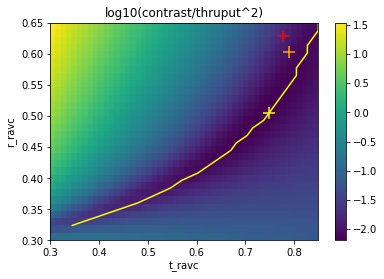

In [8]:
import matplotlib.pyplot as plt
CT2 = contrast/thruput**2
plt.imshow(np.log10(CT2), origin='lower', extent=(ts[0],ts[-1],rs[0],rs[-1]), aspect='auto')
plt.colorbar()
plt.plot(t_CT2[2:], rs[2:], c='yellow')
plt.scatter(ra_t0, ra_r0, s=150, c='red', marker='+')
plt.scatter(ra_t1, ra_r1, s=150, c='orange', marker='+')
ind_min = np.unravel_index(np.argmin(CT2, axis=None), CT2.shape)
plt.scatter(ts[ind_min[1]], rs[ind_min[0]], s=150, c='yellow', marker='+')
plt.xlabel('t_ravc');
plt.ylabel('r_ravc');
plt.title('log10(contrast/thruput^2)');
plt.savefig('map_CT2.png')
print('optimum: t=%3.4f, r=%3.4f'%(ts[ind_min[1]], rs[ind_min[0]]))